<p style="font-size:2em;"> Compressed Sensing </p>

[Cours de Guillaume Lecue](http://lecueguillaume.github.io/2015/10/08/compressed_sensing_course/)

Camille Palmier & Raphaël Huille <br>
ENSAE ParisTech

Our project is about this paper : [Robust Uncertainty Principles:
Exact Signal Reconstruction from Highly Incomplete
Frequency Information](https://arxiv.org/pdf/math/0409186.pdf) <br>

** Framework **

I - Results of the paper<br>
*We reproduce the numerical experiments of section 5. of the paper*

II - Application <br>
*We apply the method to compress and recover a black and white picture.*<br>
This part will be presented during the presentation.

** Summary of the paper **

We want to recover a dicrete temporel signal $f \in \mathbb{R}^N$ from an incomplet sub part of size $N_w$ of its fourier transform $ \hat{f} \in \mathbb{R}^N$ : $$\hat{f} = F f$$ where $F \in \mathcal{M}_{N \times N}$ is the fourier matrix : $$F_{tw} = (exp ( -2i\pi tw/N) )_{tw}$$ 

From compressed sensing theory we know that this is possible if $f$ is a sparse signal, that is $f$ is not null only for a small number of times $N_t$. 
We note $T = sup(f) = \{ t \in 1...N \ | \ f_t \neq 0  \} $ and $W$ is the subset of indices we observed from $\hat{f}$

To recover the signal we use the following procedure : 

$$ min \{ ||g||_{1} \ | \ g \in \mathbb{R}^N, \forall w \in W \quad (Fg)_w = \hat{f}_w    \} $$

We take the signal with the smallest l1 norm and which fourier transform is the same as $\hat{f}$ on $W$.

** Note about notation and conventions ** <br>
I used the following conventions to make this notebook easily readable:

- $f$ (in the code " ``` f ``` " ) is the signal in the temporel domain and $\hat{f}$  (in the code : " ``` hat_f ``` ") is the signal in the frequence domain. 
- $F$ (in the code : " ``` F ```") is the fourier matrix and $F^{-1}$ (in the code : " ``` F_inv ```") is its inverse.
- In the graph I use the color blue for signal in the temporel domain and the color red for signal in the frequence domain

# I - Results of the paper

In this section we reproduce the numerical experiments of section 5. of the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## I.1 - Context and objective

Consider a sparse signal :

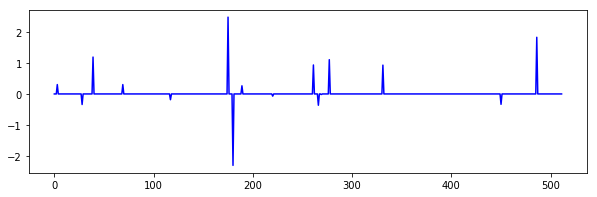

In [2]:
N = 512 #length of the signal
N_t = 16 #cardinal of the support

T = np.random.choice(np.arange(N), size = N_t, replace=False) # T is the support of the signal
f = np.random.standard_normal(N) + 1.j*np.random.standard_normal(N) # gaussian signal
f = f*np.array([i in T for i in np.arange(N)]) # 

plt.figure(figsize=(10,3))
plt.plot(f.real, c='b')
plt.show()

And suppose we observe its fourier transform :

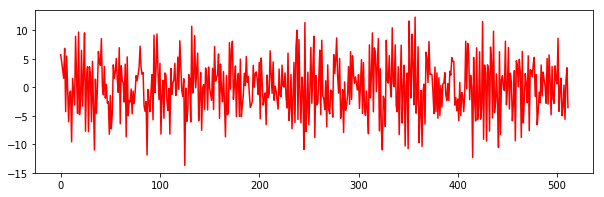

In [3]:
# Construction of the fourier matrix
u = np.reshape(np.arange(N), newshape=(N,1))
F = np.exp(-2j*np.pi*np.dot(u, u.T)/N) # Fourier Matrix

hat_f = np.dot(F,f) # fourier transform of the signal f

plt.figure(figsize=(10,3))
plt.plot(hat_f.real, c='r')
plt.show()

We can easily recover it with the inverse the fourier matrix : 

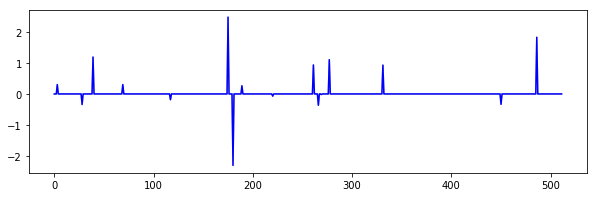

signal recovery : 100.0 %


In [4]:
def recovery_rate(f_1, f_2, t = 0.5):
    """Percentage of indices for which f_1 = f_2 = 1 for a given threshold t"""
    return np.sum(  (f_1>t)  & ( (f_1>t)==(f_2>t)) )/np.sum(f_1>t)*100

F_inv = 1/N*F.T.conjugate() #inverse fourier matrix
f_recovered = np.dot(F_inv,hat_f) # signal recovered

plt.figure(figsize=(10,3))
plt.plot(f.real, c = '0.75') #f signal will apear in grey
plt.plot(f_recovered.real, c = 'b')
plt.show()

print('signal recovery :', recovery_rate(f.real,f_recovered.real, 0.5) , '%')

But if we can observe only a random subpart of the fourier transform : <br>
*In red the part of the signal we can observe and in grey the part we canot observe*

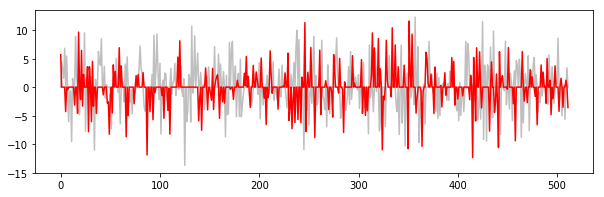

In [5]:
N_w = 200 # size of the subpart we can observed
W = np.random.choice(np.arange(N), size = N_w, replace=False) # subpart we can observed
W = np.sort(W)

hat_f_observed = hat_f * np.array([i in W for i in np.arange(N)])
hat_f_not_observed = hat_f * np.array([i not in W for i in np.arange(N)])

plt.figure(figsize=(10,3))
plt.plot(hat_f_not_observed.real, color = '0.75' )
plt.plot(hat_f_observed.real, c = 'r')
plt.show()

And if we try to use the inverse of the fourier matrix as before to recover the signal :

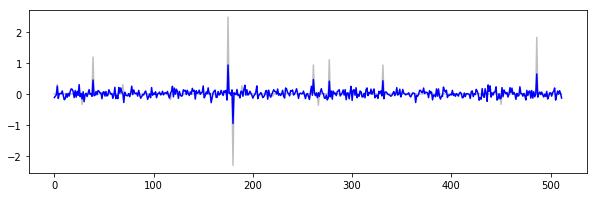

signal recovery : 33.3333333333 %


In [6]:
f_recovered = np.dot(F_inv, hat_f_observed)

plt.figure(figsize=(10,3))
plt.plot(f.real, c = '0.75')
plt.plot(f_recovered.real, c = 'b')
plt.show()

print('signal recovery :', recovery_rate(f.real,f_recovered.real) , '%')

The result is not good...

## I.2 - The basis poursuit procedure

From compressed sensing theory we get the idea to use the procedure : 

$$ min \big\{ ||g||_{1} \ | \ g \in \mathbb{C}^N, \forall w \in W \quad (Fg)_w = \hat{f}_w   \big\} $$

With : $||g||_1 = \sum_i |g_i| = \sum_i \sqrt{ re(g_i)^2 + im(g_i)^2 }$


Let's point out that this procedure is convexe but not linear as the signal is in $\mathbb{C}$. 

To do so we implement a simple gradient descent with projection algorithm as they did in the paper.

First we need to compute the gradient of the L1 norm : $\nabla ||x||_1 = \dfrac{x}{|x|} $ where $|x|$ is the vector of the module of each coordinates of $x$.

In [7]:
def norm_l1_gradient(x):
    return x/np.absolute(x)

Then, we need to project on the affine space $\big\{ x \ | \ (Fx)_w = \hat{f}_w   \big\} $ :

In [8]:
def build_projecteur(A, y):
    """build The projection matrix P onto the affine space Ax = y"""
    B = np.hstack((A,np.reshape(y, newshape=(y.shape[0],1) ) ))
    P = np.eye(B.shape[1]) - np.dot(np.linalg.pinv(B), B)
    return P
    
def projecteur(x, P, W, y):
    """ project x on the affine space """
    x = np.append(x,-1)
    r = np.dot(P, np.reshape(x, newshape=(x.shape[0], 1)))
    l = y[0]/np.dot(F[W,:][:1,:], r[:-1])
    r = r*l
    return r[:-1]

And finally we get our procedure : 

In [9]:
def gradient_projete(initialisation,W,data, n_iter=100, eta = 0.1):
    """ methode du gradient projete """
    
    P = build_projecteur(F[W,:], data)
    x = initialisation
    for i in range(n_iter):
        # direction of the descent
        gradient = norm_l1_gradient(x)
        x = x - eta*gradient
        
        # projection
        x = projecteur(x,P,W,data)
        
    return x[:,0]

We can now use it to recover the signal :

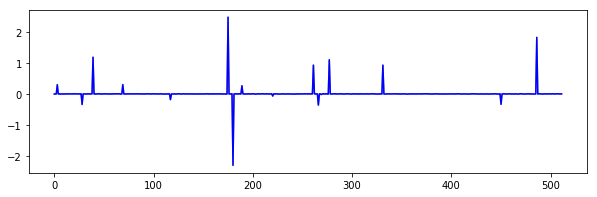

signal recovery : 100.0 %


In [10]:
# apply our method
f_recovered = gradient_projete(np.full(N, 0.1+0.1*0.j),W,hat_f[W], n_iter=1000, eta=0.01)

# visualize and check results:
plt.figure(figsize=(10,3))
plt.plot(f.real, c = '0.6')
plt.plot(f_recovered.real, c = 'b')
plt.show()

print('signal recovery :', recovery_rate(f.real,f_recovered.real) , '%')

And now we are happy

## I.3 - Simulation study

The main point of the paper is the relation between $N_t$ and $N_w$. If $N_t$ is big, that is the signal is not so sparse, we will need a biger $N_w$. In this section we explore the relation between this two quantities with simulations.

In [11]:
def simulation(rapport, N_w = 64, N = 512): 
    # To reproduce the result of the paper I choose the same parameters
    # The main problem is in the "recovery rate" definition : 
    # In the paper they did not give a precise definition of this quantity
    N_t = int(N_w*rapport)
    T = np.random.choice(np.arange(N), size = N_t, replace=False)
    W = np.random.choice(np.arange(N), size = N_w, replace=False)
    W = np.sort(W)

    f = 1 + 1.j # signal will be 0 or 1 according to the paper
    f = f*np.array([i in T for i in np.arange(N)])

    hat_f = np.dot(F,f)

    f_recovered = gradient_projete(np.full(N, 0.1+0.1*0.j),W,hat_f[W])
    
    return recovery_rate(f.real,f_recovered.real), N_t, N_w 

In [12]:
recovery_rate_list = []
for i in tqdm(np.arange(0.1,1.1, 0.1)):
    m = [simulation(i)[0] for k in range(100)]
    recovery_rate_list+=[np.mean(m)]

100%|██████████| 10/10 [01:35<00:00,  9.50s/it]


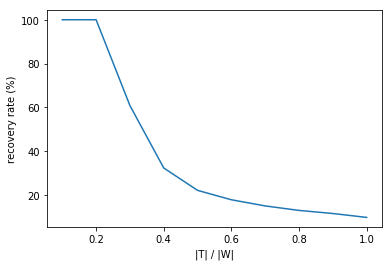

In [13]:
plt.plot(np.arange(0.1,1.1, 0.1), recovery_rate_list)
plt.xlabel("|T| / |W|")
plt.ylabel('recovery rate (%)')
plt.show()

In [17]:
recovery_rate_matrix = []

for N_w in np.arange(20,120,10):
    recovery_rate_list = []
    for rapport in tqdm(np.arange(0.1,1.1, 0.1)):
        m = [simulation(rapport, N_w=N_w)[0] for k in range(50)]
        recovery_rate_list+=[np.mean(m)]
    recovery_rate_matrix += [recovery_rate_list]

100%|██████████| 10/10 [01:00<00:00,  6.07s/it]


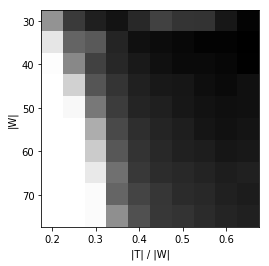

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(recovery_rate_matrix, cmap = 'gray')
ax.set_xticklabels(np.arange(0.1,1.1, 0.1))
ax.set_yticklabels(np.arange(20,120,10))
plt.xlabel("|T| / |W|")
plt.ylabel('|W|')
ax.xaxis.set_ticks_position('bottom')

plt.show()

# II - Application

This part will be presented during the presentation.